In [3]:
%pip install qiskit qiskit_aer pylatexenc

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


This project is to simulate quantum error correction using the [7,1,3] Steane code under a random Pauli error model, estimate the logical success rate, and visualize syndrome distributions.

# Introduction to the Steane Code and Syndrome Measurement

The **Steane code** is a 7-qubit quantum error-correcting code that can correct arbitrary single-qubit errors. It is one of the simplest examples of a **CSS (Calderbank-Shor-Steane)** code and is based on the classical $[7, 4, 3]$ Hamming code.

## Stabilizers of the Steane Code

The Steane code has **6 stabilizer generators**, 3 for $X$-type and 3 for $Z$-type:

```python
# Stabilizer generators (using Pauli strings for visualization)

X_stabilizers = [
    "X X X X I I I",
    "X X I I X X I",
    "X I X I X I X"
]

Z_stabilizers = [
    "Z Z Z Z I I I",
    "Z Z I I Z Z I",
    "Z I Z I Z I Z"
]
```

Each stabilizer acts on 7 physical qubits and helps detect and correct errors.

## Syndrome Measurement

To detect errors, we measure the stabilizers. The outcome of each stabilizer measurement is a **syndrome bit** (0 or 1), indicating whether the system is in the $+1$ or $-1$ eigenstate of that stabilizer.

A **syndrome** is a 6-bit string:

```python
syndrome = [s1, s2, s3, s4, s5, s6]  # 3 from Z-type, 3 from X-type
```

Where:

* The first 3 bits correspond to the measurement of $Z$-type stabilizers → detect bit-flip (X) errors
* The last 3 bits correspond to the measurement of $X$-type stabilizers → detect phase-flip (Z) errors
* The **syndrome** is a 6-bit output from measuring the stabilizers and is used to identify and fix errors.


Certainly! Here's an extended Python Markdown section that introduces the **Steane code**'s **parity-check matrix $H$** and the corresponding **syndrome table**, which maps single-qubit errors to syndromes.

## Parity-Check Matrix $H$ of the Steane Code

The Steane code is built from the classical $[7, 4, 3]$ Hamming code. Its **parity-check matrix $H$** is:

$$
H = 
\begin{bmatrix}
1 & 1 & 1 & 1 & 0 & 0 & 0 \\
1 & 1 & 0 & 0 & 1 & 1 & 0 \\
1 & 0 & 1 & 0 & 1 & 0 & 1 \\
\end{bmatrix}
$$

             
* Each **column** corresponds to one of the 7 qubits.
* Each **row** corresponds to a $Z$-type stabilizer generator (detects bit-flip $X$ errors).
* The same structure is used for $X$-type stabilizers (detects phase-flip $Z$ errors), due to CSS symmetry.
* $Z$-type stabilizers use matrix $H$ to detect $X$ errors.
* $X$-type stabilizers use matrix $H$ to detect $Z$ errors.


### **Step 1: Prepare logical Steane state $|x_L\rangle$**

This step constructs the Steane code logical state, which encodes one logical qubit into 7 physical qubits. The Steane code is a CSS code built from the classical $[7,4,3]$ Hamming code. The logical $|0_L\rangle$ and $|1_L\rangle$ states are defined as:

$$
|0_L\rangle = \frac{1}{\sqrt{8}} \sum_{c \in C} |c\rangle, \quad |1_L\rangle = \frac{1}{\sqrt{8}} \sum_{c \in C} |c \oplus 1111111\rangle
$$

where $C \subset \mathbb{F}_2^7$ is the Hamming code (even-weight codewords of the classical \[7,4,3] code). The circuit uses Hadamard gates to create superpositions and CNOTs to entangle qubits according to generator matrix $G$ of the code. If the logical input bit $x = 1$, then an $X$ gate is applied to all 7 qubits, flipping them into the complement codeword space for $|1_L\rangle$.

In [11]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister, transpile
from qiskit_aer import AerSimulator
import random
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Step 1: Prepare logical Steane state |x_L⟩
def steane_logical_state(x: int) -> QuantumCircuit:
    qc = QuantumCircuit(7, name="Encode |x_L>")
    qc.h([0, 1, 2])
    qc.cx(0, 3)
    qc.cx(1, 3)
    qc.cx(0, 4)
    qc.cx(2, 4)
    qc.cx(1, 5)
    qc.cx(2, 5)
    qc.cx(0, 6)
    qc.cx(1, 6)
    qc.cx(2, 6)
    if x == 1:
        qc.x(range(7))  # Flip all for logical 1
    return qc


### **Step 2: Apply random Pauli errors to each qubit with probability $p$**

To simulate a noisy quantum channel, this step introduces single-qubit Pauli errors on each data qubit with independent probability. For each qubit $q_i$, an error operator is applied:

$$
E_i \in \{I, X, Y, Z\}
$$

with probabilities:

$$
\Pr(E_i = X) = p,\quad \Pr(E_i = Y) = p,\quad \Pr(E_i = Z) = p,\quad \Pr(E_i = I) = 1 - 3p
$$

This approximates a depolarizing channel model. By simulating all three types of errors (bit flip, phase flip, and combined), we test the full error-correcting capability of the Steane code, which can correct **any single-qubit error**.


In [12]:
# Step 2: Apply random Pauli errors to each qubit with probability p
def apply_pauli_errors(qc: QuantumCircuit, p: float):
    for qubit in range(7):
        r = random.random()
        if r < p:
            qc.x(qubit)
        elif r < 2*p:
            qc.y(qubit)
        elif r < 3*p:
            qc.z(qubit)
    return qc

### **Step 3: Measure the 6 stabilizers (3 Z-type and 3 X-type)**

This step implements syndrome extraction via **stabilizer measurement**. The Steane code stabilizer group $\mathcal{S}$ is generated by 6 operators:

* **Z-type stabilizers**:

$$
S^Z_1 = Z_0 Z_1 Z_2 Z_4,\quad S^Z_2 = Z_0 Z_1 Z_3 Z_5,\quad S^Z_3 = Z_0 Z_2 Z_3 Z_6
$$

* **X-type stabilizers**:

$$
S^X_1 = X_0 X_1 X_2 X_4,\quad S^X_2 = X_0 X_1 X_3 X_5,\quad S^X_3 = X_0 X_2 X_3 X_6
$$

These stabilizers are measured by preparing an ancilla qubit in $|+\rangle$ or $|0\rangle$, entangling it with the data qubits using CNOT or CZ gates depending on the stabilizer type, and then measuring the ancilla in the computational basis. The measurement outcomes yield a **6-bit syndrome** $s = (s_Z, s_X) \in \mathbb{F}_2^6$, where $s_Z \in \mathbb{F}_2^3$ detects $Z$ errors and $s_X \in \mathbb{F}_2^3$ detects $X$ errors.

In [13]:
# Step 3: Measure the 6 stabilizers (3 Z-type and 3 X-type)
def measure_stabilizers(qc, data_qubits, ancilla_Z, ancilla_X, classical_bits):
    Z_gens = [[0, 1, 2, 4], [0, 1, 3, 5], [0, 2, 3, 6]]
    X_gens = [[0, 1, 2, 4], [0, 1, 3, 5], [0, 2, 3, 6]]

    for i, gens in enumerate(Z_gens):
        anc = ancilla_Z[i]
        qc.h(anc)
        for q in gens:
            qc.cz(anc, data_qubits[q])
        qc.h(anc)
        qc.measure(anc, classical_bits[i])

    for i, gens in enumerate(X_gens):
        anc = ancilla_X[i]
        qc.h(anc)
        for q in gens:
            qc.cx(anc, data_qubits[q])
        qc.h(anc)
        qc.measure(anc, classical_bits[i + 3])

    return qc


### **Step 4: Decode syndrome into integer for correction**

After measurement, we obtain a 6-bit string (e.g., `010111`) where the first 3 bits correspond to the **Z-syndrome** and the last 3 to the **X-syndrome**. These are interpreted as binary numbers:

$$
s_Z = b_2 b_1 b_0 \Rightarrow s_Z^{(int)} = 4b_2 + 2b_1 + b_0 \\
s_X = b_5 b_4 b_3 \Rightarrow s_X^{(int)} = 4b_5 + 2b_4 + b_3
$$

Each integer syndrome maps uniquely to a single-qubit error location (assuming only one error occurred). For example, syndrome $s_X = 3$ (i.e., `011`) corresponds to an $X$ error on qubit 3. This mapping uses the structure of the parity-check matrix $H$ of the Hamming code, where each column (qubit) corresponds to a syndrome vector.

Extended Syndrome Table with Integer Values

Each syndrome is a 3-bit binary string, which can be naturally interpreted as a **binary integer** from 1 to 7. This value **uniquely identifies the qubit that has an error**, assuming only a **single-qubit error** occurred.

| Qubit | $X_i$ Syndrome | $X$ Syndrome (int) | $Z_i$ Syndrome | $Z$ Syndrome (int) |
| :---: | :------------: | :----------------: | :------------: | :----------------: |
|   1   |       111      |          7         |       111      |          7         |
|   2   |       110      |          6         |       110      |          6         |
|   3   |       101      |          5         |       101      |          5         |
|   4   |       100      |          4         |       100      |          4         |
|   5   |       011      |          3         |       011      |          3         |
|   6   |       010      |          2         |       010      |          2         |
|   7   |       001      |          1         |       001      |          1         |

### **Step 5: Apply recovery operations conditionally based on decoded syndrome**

Using the decoded syndrome integers, this step applies correction gates. For each possible nonzero syndrome value $s \in \{1,2,...,7\}$, we know the index $i$ of the qubit to be corrected. The circuit includes:

$$
X_i \quad \text{if } s_X = \text{syndrome for qubit } i\\
Z_i \quad \text{if } s_Z = \text{syndrome for qubit } i
$$

These are implemented using Qiskit's `c_if()` method, so the gate is conditionally applied only when the syndrome matches. This recovers the encoded state from a single-qubit error, preserving logical information.


In [27]:
# Step 4: Decode syndrome into integer for correction
def decode_syndrome(bits):
    return int(bits, 2) if bits else 0

# Step 5: Apply recovery operations conditionally based on decoded syndrome
def syndrome_to_qubit(syndrome_bits):
    mapping = {
        '001': 0, '010': 1, '100': 2,
        '011': 3, '110': 4, '101': 5, '111': 6
    }
    return mapping.get(syndrome_bits, None)



### **Step 6: Full simulation**

This function wraps all previous steps to simulate a full cycle of **encoding → error → syndrome extraction → recovery → decoding**. A full quantum circuit is assembled with all data and ancilla qubits and classical registers. After running on a quantum simulator (e.g., `qasm_simulator`), the circuit measures both the **logical qubit** (qubit 0) and the **full data block**. The simulation is repeated for a specified number of shots, and the results are analyzed to compute the logical **success rate** — i.e., how often the output matches the original logical input.

In [34]:
# Step 6: Full simulation

def full_steane_correction_sim(x: int, p: float, shots: int = 1024):
    data = QuantumRegister(7, 'data')
    anc_Z = AncillaRegister(3, 'Z_checks')
    anc_X = AncillaRegister(3, 'X_checks')
    creg_synd = ClassicalRegister(6, 'synd')
    creg_logical = ClassicalRegister(1, 'log')
    creg_all = ClassicalRegister(7, 'cl')
    qc = QuantumCircuit(data, anc_Z, anc_X, creg_synd, creg_logical, creg_all)

    qc.compose(steane_logical_state(x), qubits=data, inplace=True)
    apply_pauli_errors(qc, p)
    measure_stabilizers(qc, data, anc_Z, anc_X, creg_synd)

    qc.measure(data[0], creg_logical[0])
    qc.measure(data, creg_all)

    simulator = AerSimulator()
    compiled_qc = transpile(qc, simulator)
    result = simulator.run(compiled_qc, shots=shots, memory=True).result()
    memories = result.get_memory()

    success_count = 0
    syndrome_list = []

    for mem in memories:
        bits = mem[::-1]
        logical_bit = int(bits[0])
        syndrome = bits[1:7]  # 6 bits: Z1 Z2 Z3 X1 X2 X3
        syndrome_list.append(syndrome)
        if logical_bit == x:
            success_count += 1

    success_rate = success_count / shots
    return success_rate, syndrome_list


### **Step 7: Run example and plot syndrome distribution**

Finally, we run the full simulation for a fixed logical input $|x_L\rangle$, noise strength $p$, and number of trials $N$. We analyze the distribution of syndromes $s \in \mathbb{F}_2^6$, count how often each occurred, and visualize the results using a histogram. This gives insight into:

* Which single-qubit errors occurred most frequently,
* How the error-correcting code responded,
* And whether the code maintained logical fidelity.

This step helps verify that the Steane code corrects errors **as expected** and provides a visual intuition for the types of syndromes produced by random noise.


raw mem = 1000010 0 010111
reversed bits = 111010 0 0100001
logical = 1, syndrome = 11010 
Logical input: |0_L⟩, Error probability: 0.05
Success rate: 0.51
First 10 syndromes:
00100 
11101 
00100 
10101 
01000 
00110 
10101 
11101 
11010 
01010 


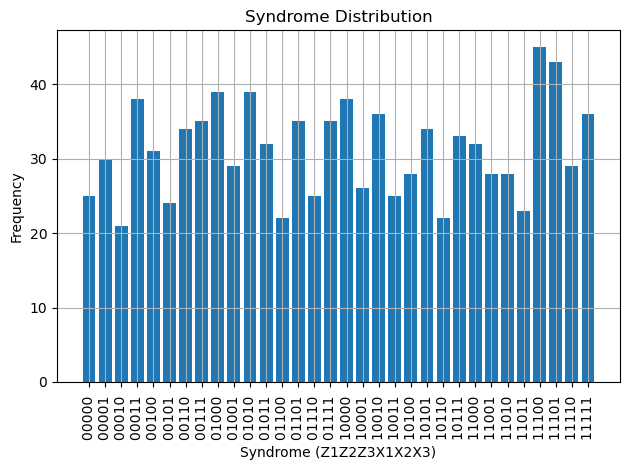

In [35]:
# Step 7: Run example and plot syndrome distribution
if __name__ == "__main__":
    x = 0
    p = 0.05
    shots = 1000
    success, syndromes = full_steane_correction_sim(x, p, shots)

    print(f"Logical input: |{x}_L⟩, Error probability: {p}")
    print(f"Success rate: {success:.2f}")
    print("First 10 syndromes:")
    for s in syndromes[:10]:
        print(s)

    counts = Counter(syndromes)
    labels, values = zip(*sorted(counts.items()))
    plt.bar(labels, values)
    plt.xticks(rotation=90)
    plt.title("Syndrome Distribution")
    plt.xlabel("Syndrome (Z1Z2Z3X1X2X3)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
